Tak jak rozmawialiśmy to jest jedynie bardzo początkowe przejrzenie tych metod (dalej tej Doc2Vec wygląda dość dziwnie), ale przynajmniej wstępne wyniki wyglądają jakby miało to jakiekolwiek szanse zadziałać :D

Sekwencja czynności przy framework'u **WL**:
1. wczytanie grafu przy założeniu, że feature'ami będą stopnie wierzchołków;
2. na podstawie stopni wierzchołków i ich sąsiadów, generujemy nowe charakterystyki $\rightarrow$ "podobny label" mają wierzchołki, które są podobnego stopnia i ich sąsiedzi są podobnych stopni;
3. na podstawie listy nowoutworzonych cech tworzona jest instancja klasy `TaggedDocument`, gdzie tagiem jest nazwa grafu;
4. utworzony w kroku $3.$ dokument podawany jest na wejściu `Doc2Vec'a`.

References:
- https://docs.cogdl.ai/en/latest/_modules/cogdl/models/emb/graph2vec.html
- https://towardsdatascience.com/beyond-weisfeiler-lehman-approximate-isomorphisms-and-metric-embeddings-f7b816b75751

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import glob

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
from tqdm.notebook import tqdm

sys.path.append('../')
from src.graph2vec import OurGraph2Vec

plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
def read_stargazers_dataset(path: str) -> Tuple[List, pd.Series]:
    """
    Function to read the graphs and their labels from github Stargazers dataset.
    Args:
        path (str): path to the dataset

    Returns:
        Tuple[List,pd.Series]: A tuple consisting of a list of NetworkX graphs and a pd.Series of their respective labels
    """
    data_path = os.path.join(path, "git_edges.json")
    target_path = os.path.join(path, "git_target.csv")
    with open(data_path) as f:
        json_content = json.load(f)
    target = pd.read_csv(target_path, index_col="id").squeeze("columns")
    return [nx.Graph(elem) for key, elem in json_content.items()], target


In [3]:
def create_logreg_model(embedding, labels, get_pred=False):
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, labels, test_size=0.3
    )
    model = LogisticRegression()
    model.fit(X_train, y_train)
    if get_pred:
        return model.predict_proba(X_test), y_test
    return 1 - (np.abs(model.predict(X_test) - y_test)).mean()


In [4]:
def calculate_measure(func, G, kwargs={}):
    return func(G, **kwargs)

In [5]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

## Parameters section

In [6]:
subset_card = 1659  # number of graphs
expt_iter_num = 1000  # number of models to train

In [7]:
MEASURES = [
    nx.pagerank,
    nx.closeness_centrality,
    nx.degree_centrality,
    nx.current_flow_closeness_centrality,
    # nx.information_centrality,  # identical to: current_flow_closeness_centrality
    nx.betweenness_centrality,
    nx.current_flow_betweenness_centrality,
    nx.approximate_current_flow_betweenness_centrality,
]

KWARGS_DICT = {
    nx.pagerank: {},
    nx.closeness_centrality: {},
    nx.degree_centrality: {},
    nx.current_flow_closeness_centrality: {},
    # nx.information_centrality: {},
    nx.betweenness_centrality: {},
    nx.current_flow_betweenness_centrality: {},
    nx.approximate_current_flow_betweenness_centrality: {},
}

## Execution section

In [8]:
graphs_subset = graphs[:subset_card]

order_dict = {}
without = OurGraph2Vec(window_size=0)  # without
with_dm = OurGraph2Vec(cbowlike=True)  # with_dm (experiment)

alpha = 1  # weight corresponding to with_dm embedding (component)
beta = 1  # weight corresponding to with_dm embedding (component)

In [9]:
# in this cell, we create a dictionary of orders with the following structure:
# order_dict = {
#    measure: nested list of nodes sorted wrt. measure
#}

for measure in tqdm(MEASURES):
    # centralities calc.
    print(f"Calculating {measure.__name__}...")
    
    centralities = [None] * subset_card
    for idx, G in tqdm(enumerate(graphs_subset), total=subset_card):
        centralities[idx] = calculate_measure(func=measure, G=G, kwargs=KWARGS_DICT[measure])
        
    # ordering wrt. centralities
    print(f"Ordering wrt. {measure.__name__}...")
    ams = [None for i in range(subset_card)]

    for it, central_dict in tqdm(enumerate(centralities), total=subset_card):
        ams[it] = np.array(sorted(central_dict, key=central_dict.get), dtype=np.int64)
        
    order_dict[measure] = ams

  0%|          | 0/7 [00:00<?, ?it/s]

Calculating pagerank...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. pagerank...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating closeness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. closeness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating degree_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. degree_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating current_flow_closeness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. current_flow_closeness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating current_flow_betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. current_flow_betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Calculating approximate_current_flow_betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

Ordering wrt. approximate_current_flow_betweenness_centrality...


  0%|          | 0/1659 [00:00<?, ?it/s]

'pagerank'

  0%|          | 0/1000 [00:00<?, ?it/s]

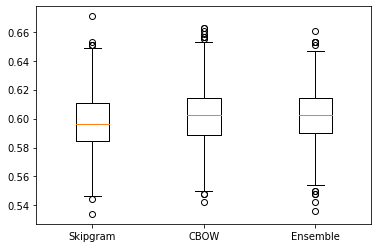

'closeness_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

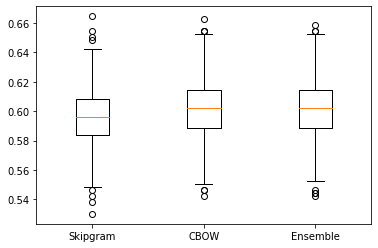

'degree_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

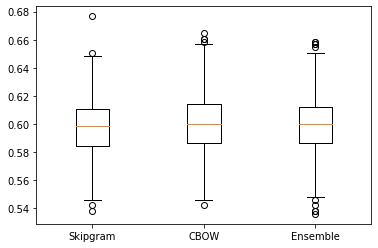

'current_flow_closeness_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

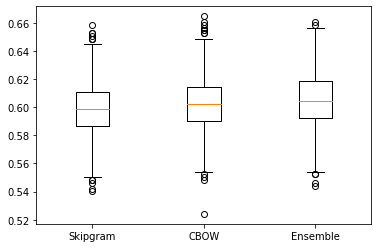

'betweenness_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

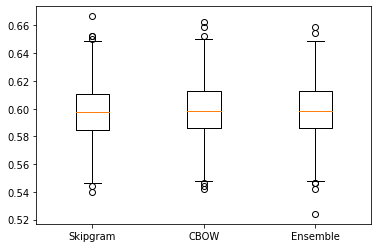

'current_flow_betweenness_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

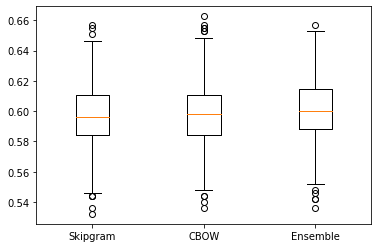

'approximate_current_flow_betweenness_centrality'

  0%|          | 0/1000 [00:00<?, ?it/s]

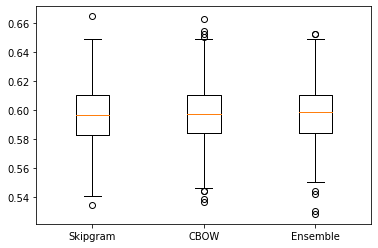

In [10]:
# in this cell we run experiments for all measures

for measure, order in order_dict.items():
    display(measure.__name__)
    
    # benchmark
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    
    # experiment
    no_dm_res = [0] * expt_iter_num
    dm_res = [0] * expt_iter_num
    ens_res = [0] * expt_iter_num

    for it in tqdm(range(expt_iter_num)):
        no_dm_res[it] = create_logreg_model(
            without.get_embedding(), labels=labels[:subset_card]
        )
        dm_res[it] = create_logreg_model(
            with_dm.get_embedding(), labels=labels[:subset_card]
        )

        # TODO: weighted ensemble of embeddings
        ens_res[it] = create_logreg_model(
            alpha*with_dm.get_embedding()+beta*without.get_embedding(),
            labels=labels[:subset_card]
        )
    
    # results
    res_nested_list = [
        no_dm_res,
        dm_res,
        ens_res
    
    ]
    axis_labels = [
        'Skipgram',
        'CBOW',
        'Ensemble'
    ]

    n_items = len(res_nested_list)
    plt.boxplot(res_nested_list, positions=range(n_items))
    plt.xticks(range(n_items), labels=axis_labels[:n_items])
    plt.show()